In [1]:
import mmh3
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import math
import matplotlib.pyplot as plt

In [2]:
max_priority = 7
color_table = ['red', 'green', 'blue', 'c', 'pink', 'purple', 'orange', 'crimson', 'skyblue', 'chocolate', 'violet', 'navy']
color_lst = [color_table[i] for i in range(max_priority)]
mea_T = 0
m = 50 * 1024 * 8 // 3
print("总共:", m, "个寄存器.")
pre_p_lst = [0.15, 0.173, 0.21, 0.261, 0.341, 0.502, 0.913]
post_p_lst = [0.367, 0.367, 0.367, 0.367, 0.367, 0.367, 0.367]
prob_lst = [round(pre_p_lst[i],3) * round(post_p_lst[i],3) - 0.001 for i in range(max_priority)]
#暴力搜索出来的最优解[0.01, 0.225, 0.356, 0.387, 0.377, 0.351, 0.321]
high_priority_flows = set([6,7])
med_priority_flows = set([])
low_priority_flows = set([1,2,3,4,5])

总共: 136533 个寄存器.


In [3]:
map_dict = {6: 6, 7 : 7, 4 : 4, 5 : 5, 1 : 1, 2 : 2, 3 : 3}

In [4]:
def judge(a, b):
    flag = False
    if a in low_priority_flows:
        if b in med_priority_flows:
            flag = True
        elif b in high_priority_flows:
            flag = True
    elif a in med_priority_flows:
        if b in high_priority_flows:
            flag = True
    elif a == 0:
        flag = True
    return flag
# 定义高优先级占所有优先级的20%，对于10个优先级，9、10优先级流为高优先级流，剩余优先级流为低优先级流
class RegFilter:
    '''
    :params
      (1) m: 寄存器数目
      (2) prob_lst: 不同优先级流的采样频率
      (3) 最大优先级数目
    '''
    def __init__(self, m, pre_lst, post_lst, max_prior):
        self.pre_sampling_lst = pre_lst
        self.pre_sample_seed = 21321
        self.sample_seed = 98123
        self.hash_seed = 13123
        self.m = m
        self.max_prior = max_prior
        self.pre_p = pre_lst
        self.post_p = post_lst
        self.prob_lst = [round(self.pre_p[i] * self.post_p[i] - 0.0001, 3) for i in range(max_priority)]
        print(self.prob_lst)
        self.R = np.zeros(shape = (self.m, ), dtype = np.int8)
        self.c = np.zeros(shape = (self.max_prior, ), dtype = np.int32)
        self.are = 0
        self.flow_count = 0
        self.are_dict = {}
        self.fine_are_dict = {}
        self.class_are_dict = {'low':0, 'med':0, 'high':0}
        self.real_set_dict = {}
        self.flow_count_dict = {}
        self.flow_count_p = {'low':0, 'med':0, 'high':0}
        self.real_dict = {}
        self.pred_dict = {}
        self.hash_table = {}
        self.downloads = 0
        for i in range(1, max_priority + 1):
            self.flow_count_dict[i] = 0
        self.hash_collisions_for_highest = defaultdict(set) # 仅仅统计最高优先级的类内哈希冲突
        for i in range(1, self.max_prior + 1): # 默认优先级从1开始
            self.are_dict[i] = 0
            self.fine_are_dict[i] = {0:0 ,1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
            self.real_dict[i] = defaultdict(int)
            self.pred_dict[i] = defaultdict(int)
            self.real_set_dict[i] = defaultdict(set)
            self.hash_table[i] = defaultdict(int)
        
    def update(self, src, dst, p):
        p_new = map_dict[p]
        pre_sample_idx = mmh3.hash(src + dst, seed = self.pre_sample_seed) % 0xffffffff
        if pre_sample_idx > self.pre_sampling_lst[p_new - 1] * 0xffffffff:
            return
        hash_idx = mmh3.hash(src + dst, seed = self.hash_seed) % self.m
        if self.R[hash_idx] < p_new: #if judge(self.R[hash_idx], p):
            if self.R[hash_idx] != 0:
                self.c[self.R[hash_idx] - 1] -= 1 
            self.R[hash_idx] = p_new
            self.c[p_new - 1] += 1
            sample_idx = mmh3.hash(src + dst, seed = self.sample_seed) % 0xffffffff
            if sample_idx <= self.post_p[p - 1] * 0xffffffff:
                self.hash_table[p][src] += 1
                self.downloads += 1
            sum_ = 0
            for j in range(p_new - 1, self.max_prior): # 原先为max_prior
                sum_ += self.c[j]
            self.post_p[p - 1] = (self.m * self.prob_lst[p - 1]) / (self.m - sum_) / self.pre_sampling_lst[p_new - 1]
        elif self.R[hash_idx] == p_new:
            if p == max_priority:
                self.hash_collisions_for_highest[hash_idx].add(src + " + " + dst)
    
    def estimate(self, src):
        for i in range(1, self.max_prior + 1):
            if src in self.hash_table[i]:
                return int(self.hash_table[i][src] / self.prob_lst[i - 1])
        else:
            return 0
    
    def run(self, filename):
        N = set([])
        f = open(filename, 'r')
        data = f.readlines()
        print("[Message] 实验数据导入完毕")
        for pkt in tqdm(data):
            src, dst, p = pkt.split()
            p = int(p)
            N.add(src + "+" + dst)
            self.real_set_dict[p][src].add(dst)
            self.update(src, dst, p)
        print("[Message] 更新数据完毕")
        for i in range(1, self.max_prior + 1):
            for key in tqdm(self.real_set_dict[i]):
                # 【注意！任务改变，需要估计过阈值的流】
                if len(self.real_set_dict[i][key]) >= mea_T:
                    self.real_dict[i][key] = len(self.real_set_dict[i][key])
                    self.pred_dict[i][key] = self.estimate(key)
        print("[Message] 估计阶段完成")
        print("总共有{}个不同元素.".format(len(N)))
        f.close()
    
    def draw(self):
        x = np.arange(math.log10(mea_T) if mea_T != 0 else 0, 7, 1)
        high_flow_count = 0
        low_flow_count = 0
        med_flow_count = 0
        for i in range(1, self.max_prior + 1):
            x_log, y_log = [], []
            # 临时记录该优先级流下每个基数范围内的流数目
            temp_range_count = defaultdict(int)
            for key in self.real_dict[i]:
                temp_v = abs(self.pred_dict[i][key] - self.real_dict[i][key]) / self.real_dict[i][key]
                self.are_dict[i] += temp_v
                self.are += temp_v
                self.flow_count += 1
                temp_range_count[int(round(math.log10(self.real_dict[i][key])))] += 1
                self.fine_are_dict[i][int(round(math.log10(self.real_dict[i][key])))] += temp_v
                self.flow_count_dict[i] += 1
                if i in high_priority_flows:
                    self.class_are_dict['high'] += temp_v
                    self.flow_count_p['high'] += 1
                elif i in med_priority_flows:
                    self.class_are_dict['med'] += temp_v
                    self.flow_count_p['med'] += 1
                elif i in low_priority_flows:
                    self.class_are_dict['low'] += temp_v
                    self.flow_count_p['low'] += 1
                x_log.append(self.real_dict[i][key])
                y_log.append(self.pred_dict[i][key])
            for j in range(0, 7):
                if temp_range_count[j] == 0:
                    self.fine_are_dict[i][j] = 0
                else:
                    self.fine_are_dict[i][j] = self.fine_are_dict[i][j] / temp_range_count[j]
            x_log = np.log10(x_log)
            y_log = np.log10(y_log)
            plt.plot(x_log, y_log, '*', color = color_lst[i - 1], label = str(i) + "-priority flow")
        for i in range(1, max_priority + 1):
            self.are_dict[i] = self.are_dict[i] / self.flow_count_dict[i] if self.flow_count_dict[i] != 0 else None
        self.class_are_dict['high'] = self.class_are_dict['high'] / self.flow_count_p['high'] if self.flow_count_p['high'] != 0 else None
        self.class_are_dict['med'] = self.class_are_dict['med'] / self.flow_count_p['med'] if self.flow_count_p['med'] != 0 else None
        self.class_are_dict['low'] = self.class_are_dict['low'] / self.flow_count_p['low'] if self.flow_count_p['low'] != 0 else None
        plt.plot(x, x)
        plt.legend()
        plt.xlabel("Real spreads")
        plt.ylabel("Estimated spreads")
        plt.tight_layout()
        plt.savefig("Regfilter_100KB.jpg")
        plt.show()
        print("total are is ", self.are / self.flow_count)

In [5]:
bit = math.ceil(math.log2(max_priority + 1))
regfilter = RegFilter(m, pre_p_lst, post_p_lst, max_priority)
print("总共占用存储空间{}KB, 共{}比特.".format(m * bit / 8 / 1024, m * bit))
regfilter.run("./CAIDA 2016/00_7.txt")
#regfilter.run("./CAIDA 2016/00_7.txt")
print("regfilter总共下载{}个元素.".format(regfilter.downloads))

  0%|          | 0/907463 [00:00<?, ?it/s]

[0.055, 0.063, 0.077, 0.096, 0.125, 0.184, 0.335]
总共占用存储空间49.9998779296875KB, 共409599比特.
[Message] 实验数据导入完毕


  0%|          | 0/82128 [00:00<?, ?it/s]

[Message] 更新数据完毕


100%|██████████| 94388/94388 [00:00<00:00, 457963.94it/s]

[Message] 估计阶段完成
总共有907463个不同元素.
regfilter总共下载113414个元素.


/home/tmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in log10
/home/tmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in log10
/home/tmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in log10
/home/tmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in log10
/home/tmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in log10
/home/tmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in log10
/home/tmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in log10


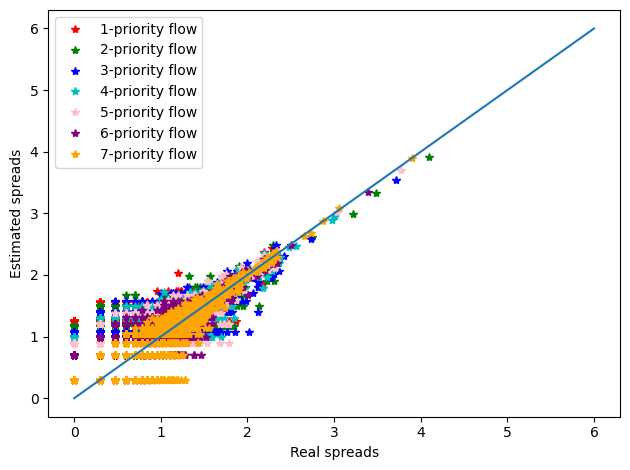

total are is  1.4557053925458319


In [6]:
regfilter.draw()

In [7]:
print(regfilter.are_dict)
print("[Message] 更细粒度的are指标如下所示")
for i in range(1, max_priority + 1):
    print("[Message] 第{}优先级流的are信息如下:".format(i))
    for j in range(0, 7, 1):
        if regfilter.fine_are_dict[i][j] != 0:
            print("  第{}个区间内的are为{}".format(j, regfilter.fine_are_dict[i][j]))
print("下面以后两个优先级流为高优先级流，显示高低优先级流的基数估计ARE:")
print(regfilter.class_are_dict)

{1: 1.5932370977348527, 2: 1.5611310244819858, 3: 1.556466278736752, 4: 1.5849441829798365, 5: 1.5938704531115282, 6: 1.444863128344216, 7: 0.9314565827266841}
[Message] 更细粒度的are指标如下所示
[Message] 第1优先级流的are信息如下:
  第0个区间内的are为1.607858447201058
  第1个区间内的are为1.2102121491584068
  第2个区间内的are为0.4036426195624708
[Message] 第2优先级流的are信息如下:
  第0个区间内的are为1.5754056720616327
  第1个区间内的are为1.1687533936345644
  第2个区间内的are为0.49886618629893453
  第3个区间内的are为0.32556956459379627
  第4个区间内的are为0.3410252315554136
[Message] 第3优先级流的are信息如下:
  第0个区间内的are为1.5752203350259733
  第1个区间内的are为1.050196992032529
  第2个区间内的are为0.3823618661778495
  第3个区间内的are为0.27425373134328357
  第4个区间内的are为0.3279662641364769
[Message] 第4优先级流的are信息如下:
  第0个区间内的are为1.6075666784161662
  第1个区间内的are为0.9879257539894243
  第2个区间内的are为0.3095525573391584
  第3个区间内的are为0.15767352231375018
[Message] 第5优先级流的are信息如下:
  第0个区间内的are为1.6193915572412734
  第1个区间内的are为0.9127743996105699
  第2个区间内的are为0.2983846678678551
  第3个区间内的are为0.04936014625228519
  第4个区间内的a

In [8]:
for idx, c in enumerate(regfilter.c):
    sum_ = 0
    for j in range(idx, len(regfilter.c)):
        sum_ += regfilter.c[j]
    print("值大于等于{}的寄存器占所有寄存器数组的{}".format(idx + 1, sum_ / regfilter.m))

值大于等于1的寄存器占所有寄存器数组的0.9182908161396879
值大于等于2的寄存器占所有寄存器数组的0.9068283858114888
值大于等于3的寄存器占所有寄存器数组的0.8894406480484571
值大于等于4的寄存器占所有寄存器数组的0.8656515274695494
值大于等于5的寄存器占所有寄存器数组的0.8292647198845701
值大于等于6的寄存器占所有寄存器数组的0.7648114375279237
值大于等于7的寄存器占所有寄存器数组的0.6319131638504977


In [9]:
mdict = regfilter.hash_collisions_for_highest
hash_times = 0
for idx in mdict:
    hash_times += len(mdict[idx]) - 1
print("最高优先级哈希冲突: {}".format(hash_times))

最高优先级哈希冲突: 13926
